In [40]:
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn import svm

### Goal
- Implement the kernelized support vector machine 
- Understand the optimization of the dual formulation of SVM. 

### 1. Load up and normalize the data
Here there are data for individuals' income, credit limit, credit rating, etc. and a few binary variables.  We can try to use a few of these features to predict one of the binary variables.  

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
def sklearn_to_df(data_loader):
    X_data = data_loader.data
    X_columns = data_loader.feature_names
    x = pd.DataFrame(X_data, columns=X_columns)

    y_data = data_loader.target
    y = pd.Series(y_data, name='target')

    return x, y

# Loading a classic binary classification dataset (breast cancer prediction from 30 features).
# More details: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
x, y = sklearn_to_df(load_breast_cancer())

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

Write the code that normalize the data so that our data centers at 0 and has a min and max of -1 and 1.
See https://cs231n.github.io/neural-networks-2/#datapre
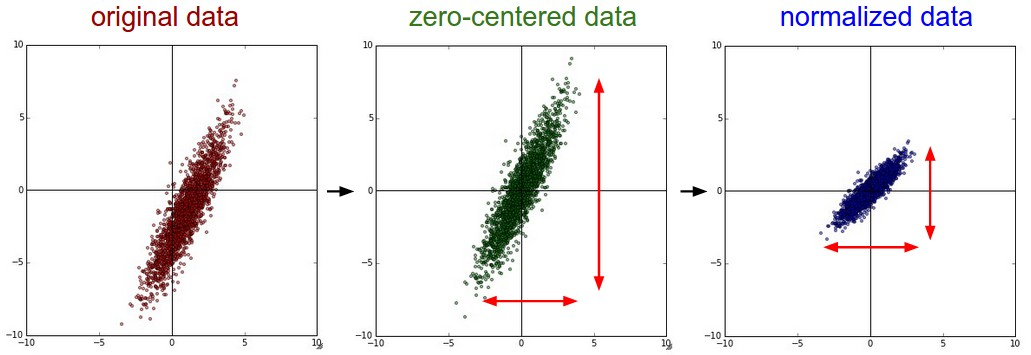

In [42]:
def normalize_data(x_train, x_test):
    '''
    Compute the mean and std statistics of the training data
    And normalize BOTH training and test data using the above statistics
    '''
    # TODO: EDIT THIS FUNCTION
    x_train_normalized = x_train
    x_test_normalized = x_test

    x_train_normalized -= np.mean(x_train, axis = 0)
    x_test_normalized -= np.mean(x_test, axis = 0)
    
    x_train_normalized /= np.std(x_train, axis = 0)
    x_test_normalized /= np.std(x_test, axis = 0)

    return x_train_normalized, x_test_normalized

x_train, x_test = normalize_data(x_train, x_test)

In [43]:
x_train.head()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
68     -1.440753     -0.435319       -1.362085  -1.139118         0.780573   
181     1.974096      1.733026        2.091672   1.851973         1.319843   
63     -1.399982     -1.249622       -1.345209  -1.109785        -1.332645   
248    -0.981797      1.416222       -0.982587  -0.866944         0.059390   
60     -1.117700     -1.010259       -1.125002  -0.965942         1.269511   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
68           0.718921        2.823135            -0.119150       1.092662   
181          3.426275        2.013112             2.665032       2.127004   
63          -0.307355       -0.365558            -0.696502       1.930333   
248         -0.596788       -0.820203            -0.845115       0.313264   
60          -0.439002       -0.983341            -0.930600       3.394436   

     mean fractal dimension  ...  worst radius  worst texture  \
68                 2.458173  ...     -1.232861      -0.476309   
181                1.558396  ...      2.173314       1.311279   
63                 0.954379  ...     -1.295284      -1.040811   
248                0.074041  ...     -0.829197       1.593530   
60                 0.950213  ...     -1.085129      -1.334616   

     worst perimeter  worst area  worst smoothness  worst compactness  \
68         -1.247920   -0.973968          0.722894           1.186732   
181         2.081617    2.137405          0.761928           3.265601   
63         -1.245220   -0.999715         -1.438693          -0.548564   
248        -0.873572   -0.742947          0.796624          -0.729392   
60         -1.117138   -0.896549         -0.174876          -0.995079   

     worst concavity  worst concave points  worst symmetry  \
68          4.672828              0.932012        2.097242   
181         1.928621              2.698947        1.891161   
63         -0.644911             -0.970239        0.597602   
248        -0.774950             -0.809483        0.798928   
60         -1.209146             -1.354582        1.033544   

     worst fractal dimension  
68                  1.886450  
181                 2.497838  
63                  0.057894  
248                -0.134497  
60                 -0.205732  

[5 rows x 30 columns]

### 2. Create training data and target labels

since we have 400 data points to work with, I'll use half to train and half to validate

In [44]:
# The original data labels are 0 and 1 but our SVM binary classifier outputs -1 and 1.
# So we replace all 0 labels with -1
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

y_test

204    1
70    -1
131   -1
431    1
540    1
      ..
486    1
75    -1
249    1
238    1
265   -1
Name: target, Length: 114, dtype: int64

### 3. Dual formulation of SVM

given data points $\vec x_j \in \mathbb{R}^{1 \times N}$ and targets $y_j = \pm 1$, where $j = 1, \dots, M$, find the maximum-margin hyperplane that separates the two classes ($y_j = 1$ and $y_j = -1$).  

Let $\vec w$ be the vector normal to the hyperplane.  We want to find $\vec w$ that satisfies 

$$ y_j (\vec w \cdot \vec x_j + b) \geq 1 $$

The dual formulation of the above is equivalent to maximizing the following over the multipliers $\vec \alpha$:

$$ L(\vec \alpha) = \vec y \cdot \vec \alpha  - \frac 1 2  \vec \alpha K \vec \alpha^T$$

subject to the constraints $\sum_{j=1}^M \alpha_j = 0$ and $y_j \alpha_j \geq 0$.  The matrix $K$ defines the kernel of the SVM; I've chosen $K_{jk} = k(\vec x_j, \vec x_k) = \vec x_j \cdot \vec x_k$.  The parameters of the plane are recovered from $\vec w = \vec \alpha \cdot \vec x$ and $b = y_j = \vec w \cdot \alpha_j$ for $j$ such that $\alpha_j \neq 0$

for reference see eq(1) from:
https://arxiv.org/pdf/1307.0471.pdf

### 4. Make the kernel matrix from training data
since I've defined the kernel as a symmetric bilinear form, the kernel matrix defining the transformation should also be symmetric.  Further, since $ k (\vec x_j, \vec x_k) \equiv \vec x_j \cdot \vec x_k$ the transformation (and thus the matrix) is positive semidefinite ($x_j^i$ admits entries equal to zero).  This is a well known result for linear kernels.  

We can construct the $K$ matrix as follows.  

In [45]:
def kernel(X):
    '''
      Returns a kernel matrix of N x N with N being the number of training-set examples
    '''
    return (np.dot(X, X.T) + 1)**5 #TODO: COMPLETE THIS LINE


# Kernel matrix
X = np.array(x_train)
K = kernel(X)

K

array([[ 1.23185308e+11,  2.45871906e+07,  1.05456264e+07, ...,
        -9.48553768e+07,  8.12054187e+01, -1.02775135e+07],
       [ 2.45871906e+07,  1.01615456e+10, -9.08605622e+06, ...,
        -9.41496405e+07,  8.73832423e+05, -2.10643128e+07],
       [ 1.05456264e+07, -9.08605622e+06,  6.71330992e+07, ...,
         7.53206608e+02, -1.10374368e+05,  3.17586557e+03],
       ...,
       [-9.48553768e+07, -9.41496405e+07,  7.53206608e+02, ...,
         4.99390874e+07, -3.22899605e+03,  3.13440658e+06],
       [ 8.12054187e+01,  8.73832423e+05, -1.10374368e+05, ...,
        -3.22899605e+03,  2.00298354e+05, -1.30771042e-01],
       [-1.02775135e+07, -2.10643128e+07,  3.17586557e+03, ...,
         3.13440658e+06, -1.30771042e-01,  2.41145729e+06]])

If the Kernel matrix is not PSD.
You'd need to apply a trick of adding a small constant value along $K$'s diagonal entries to ensure numerical stability.

A positive semidefinite matrix is a Hermitian matrix all of whose eigenvalues are nonnegative.
https://mathworld.wolfram.com/PositiveSemidefiniteMatrix.html

In [46]:
# Check if our K matrix is positive semi definite (i.e. all eigenvalues are non-negative)
is_PSD = np.all(np.linalg.eigvals(K) >= 0) # TODO: COMPLETE THIS LINE
print("Is matrix positive semi-definite:", is_PSD)

Is matrix positive semi-definite: True


### 5. Minimize the dual loss and solve for $\alpha \in R^n$

`cvxpy` is a package that allows the user to express a convex optimization problem in a readable form, converts it into a form that can be used to call a solver, solves, and then translates the result again into a readable form.  We use `cvxpy` to encode the dual problem that has the following objective function:

In [47]:
alpha = cp.Variable(shape=y_train.shape)

beta = cp.multiply(alpha, y_train) # to simplify notation
print(beta.shape)
K = cp.Parameter(shape=K.shape, PSD=True, value=K)
print(K.shape)

# objective function
obj = .5 * cp.quad_form(beta, K) - np.ones(alpha.shape).T @ alpha

# constraints
const = [np.array(y_train.T) @ alpha == 0,
        -alpha <= np.zeros(alpha.shape),
        alpha <= 10*np.ones(shape=alpha.shape)]
prob = cp.Problem(cp.Minimize(obj), const)

(455,)
(455, 455)


In [48]:
result = prob.solve()

/usr/local/lib/python3.9/dist-packages/cvxpy/reductions/solvers/solving_chain.py:200: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


6. Recreate the hyperplane (i.e. $w$ and $b$) from alphas $\alpha$

In [49]:
W = np.multiply(y_train, alpha.value).T @ x_train

S = (alpha.value > 1e-4).flatten()
b = y_train[S] - x_train[S] @ W
b = np.mean(b)

### Define and test our SVM classifier
Given the tuned parameters for the hyperplane

In [50]:
def classify(x):
    result = W @ x + b
    return np.sign(result)

In [51]:
correct = 0
for i, x in x_test.iterrows():
    if classify(x) == y_test[i]: 
        correct +=1

print(f"accuracy: {correct/x_test.shape[0]}")

accuracy: 0.956140350877193


The above is the fraction of points for which my SVM correctly predicted the target 

### Compare to sklearn_svm

In [52]:
sklearn_svm = svm.SVC(C = 1, kernel='poly')
sklearn_svm.fit(x_train, y_train)

sklearn_svm.score(x_test, y_test)

0.868421052631579